## 0 Imports

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import datetime

### 0.1 Helper Functions

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mse = mean_squared_error(y, yhat)

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse,
                         'MSE': mse}, 
                        index=[0])

def cross_validation(X, y, model, kfold=5):
    """
    Realiza a validação cruzada em k folds.
    
    Parâmetros:
    - X: DataFrame ou array com as variáveis explicativas.
    - y: Series ou array com a variável resposta.
    - model: Instância do modelo a ser avaliado.
    - kfold: Número de folds para a validação cruzada.

    Retorna:
    - DataFrame com as métricas de erro média e desvio padrão.
    """
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
    
    mae_list = []
    mse_list = []
    rmse_list = []
    mape_list = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_val)
        
        # Calculando as métricas
        mae = np.mean(np.abs(y_val - y_pred))
        mse = np.mean((y_val - y_pred) ** 2)
        rmse = np.sqrt(mse)
        
        # MAPE
        mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100  # Multiplicado por 100 para porcentagem
        
        mae_list.append(mae)
        mse_list.append(mse)
        rmse_list.append(rmse)
        mape_list.append(mape)
    
    return pd.DataFrame({
        'MAE': [np.mean(mae_list), np.std(mae_list)],
        'MSE': [np.mean(mse_list), np.std(mse_list)],
        'RMSE': [np.mean(rmse_list), np.std(rmse_list)],
        'MAPE': [np.mean(mape_list), np.std(mape_list)]
    }, index=['Mean', 'Std'])

### 0.2 - Load Data

In [7]:
data_raw = pd.read_csv('C:/Users/Alexandre/Documents/TCC - Data Science e Analytics/beer_reviews.csv')

## 1 Data Description

### 1.1 Data Preview

In [8]:
data = data_raw.copy()
data.head(5)

,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.50,2.00,2.50,stcules,Hefeweizen,1.50,1.50,Sausa Weizen,5.00,47986
1,1,10325,Vecchio Birraio,1235915097,3.00,2.50,3.00,stcules,English Strong Ale,3.00,3.00,Red Moon,6.20,48213
2,2,10325,Vecchio Birraio,1235916604,3.00,2.50,3.00,stcules,Foreign / Export Stout,3.00,3.00,Black Horse Black Beer,6.50,48215
3,3,10325,Vecchio Birraio,1234725145,3.00,3.00,3.50,stcules,German Pilsener,2.50,3.00,Sausa Pils,5.00,47969
4,4,1075,Caldera Brewing Company,1293735206,4.00,4.50,4.00,johnmichaelsen,American Double / Imperial IPA,4.00,4.50,Cauldron DIPA,7.70,64883


### 1.2 Data Dimension

In [9]:
print('Number of rows: {}'.format(data.shape[0]))
print('Number of columns: {}'.format(data.shape[1]))

Number of rows: 1586614
Number of columns: 14


### 1.3 Rename Columns

In [10]:
data.rename(columns={'beer_abv': 'beer_alcohol_by_volume'}, inplace=True)

### 1.3 Data Types

In [11]:
data.dtypes

index                       int64
brewery_id                  int64
brewery_name               object
review_time                 int64
review_overall            float64
review_aroma              float64
review_appearance         float64
review_profilename         object
beer_style                 object
review_palate             float64
review_taste              float64
beer_name                  object
beer_alcohol_by_volume    float64
beer_beerid                 int64
dtype: object

### 1.4 Change dtypes


In [12]:

data['review_time'] = pd.to_datetime(data['review_time'], unit='s')
data['beer_beerid'] = data['beer_beerid'].astype('string')
data['brewery_id'] = data['brewery_id'].astype('string')

data = data.drop(columns=['index'])


### 1.5 Check NA's


In [13]:
data.isna().sum()

brewery_id                    0
brewery_name                 15
review_time                   0
review_overall                0
review_aroma                  0
review_appearance             0
review_profilename          348
beer_style                    0
review_palate                 0
review_taste                  0
beer_name                     0
beer_alcohol_by_volume    67785
beer_beerid                   0
dtype: int64

### 1.6 Fillout NA's


In [14]:
#encontrando a média dos teores alcoólicos por tipo de cerveja 
mean_by_beer_style = data.groupby('beer_style')['beer_alcohol_by_volume'].transform('mean')

#atribuindo a média para cada grupo nos valores ausentes
data['beer_alcohol_by_volume'] = data['beer_alcohol_by_volume'].fillna(mean_by_beer_style)

#atribuindo o termo "unidentified reviewer" aos usuários não identificados
unidentified_reviewer = "unindentified_reviewer"
data['review_profilename'] = data['review_profilename'].fillna(unidentified_reviewer)

#excluindo as linhas que não possuem cervejaria preenchida
data = data.dropna(subset=['brewery_name'])

#para as sete observações iguais a 0 em review_overall e review_appearance atribuir a nota mínima
data.loc[(data['review_overall'] == 0) & (data['review_appearance'] == 0), ['review_overall', 'review_appearance']] = 1

### 1.7 Descriptive Statistical


In [15]:
num_attributes = data.select_dtypes(include=['int64','float64'])
cat_attributes = data.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [16]:
#medidas de Tendência Central
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#medidas de dispersão

dm1 = pd.DataFrame(num_attributes.apply(np.min)).T
dm2 = pd.DataFrame(num_attributes.apply(np.max)).T
dm3 = pd.DataFrame(num_attributes.apply(np.std)).T
dm4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dm5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dm6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenando para melhorar a visualização
numerical_metrics = pd.concat([dm1,dm2,dm4,ct1,ct2,dm3,dm5,dm6]).T.reset_index()

#renomeando as colunas
numerical_metrics.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

#exibindo o resultado
numerical_metrics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,review_overall,1.00,5.00,4.00,3.82,4.00,0.72,-1.02,1.63
1,review_aroma,1.00,5.00,4.00,3.74,4.00,0.70,-0.84,1.15
2,review_appearance,1.00,5.00,4.00,3.84,4.00,0.62,-0.90,1.73
3,review_palate,1.00,5.00,4.00,3.74,4.00,0.68,-0.87,1.30
4,review_taste,1.00,5.00,4.00,3.79,4.00,0.73,-0.97,1.34
5,beer_alcohol_by_volume,0.01,57.70,57.69,7.00,6.50,2.30,1.57,7.09


#### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

brewery_id             5838
brewery_name           5742
review_profilename    33388
beer_style              104
beer_name             56848
beer_beerid           66044
dtype: int64

### 1.8 Outliers Analysis

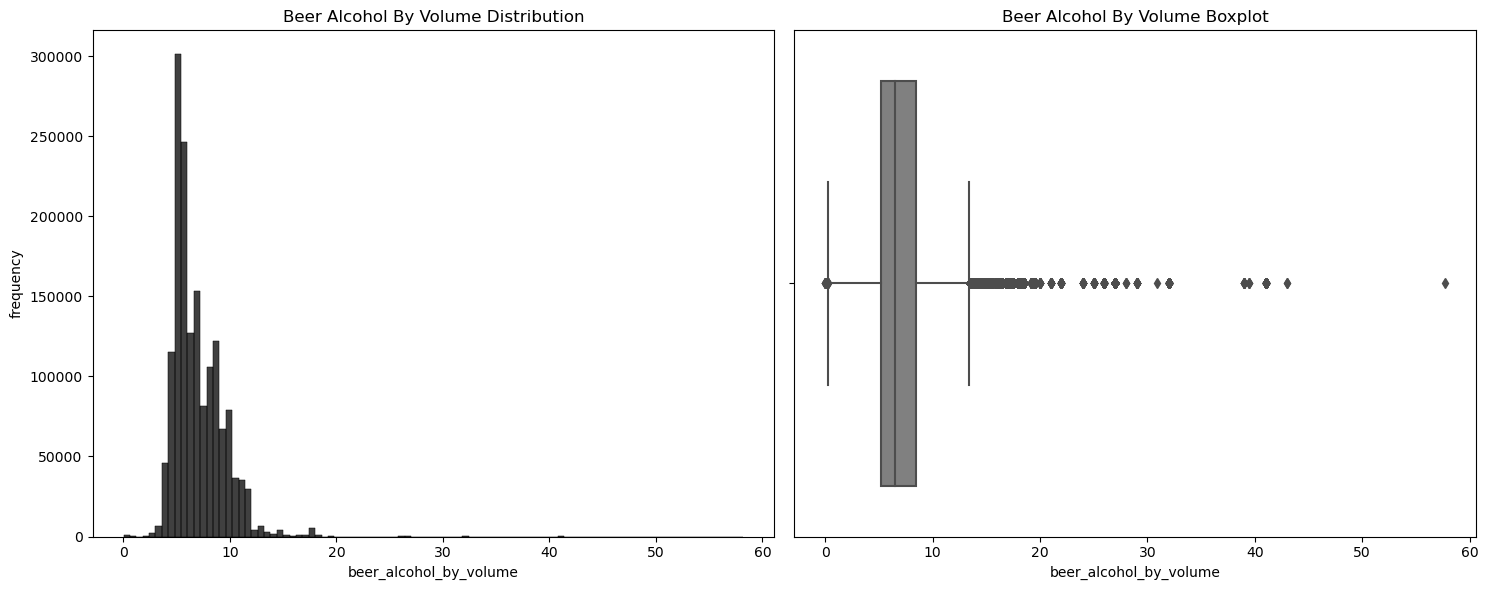

In [18]:
#criando o esquema da figura
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 linha, 2 colunas

#histograma
sns.histplot(data=data, 
              x='beer_alcohol_by_volume', 
              color='black',
              binwidth=0.6, 
              ax=axes[0])
axes[0].set_title('Beer Alcohol By Volume Distribution')
axes[0].set_xlabel('beer_alcohol_by_volume')
axes[0].set_ylabel('frequency')

#boxplot
sns.boxplot(x=data['beer_alcohol_by_volume'], color='gray', ax=axes[1])
axes[1].set_title('Beer Alcohol By Volume Boxplot')
axes[1].set_xlabel('beer_alcohol_by_volume')

plt.tight_layout()
plt.show()

In [19]:
# #identificando os limites de IQR
# Q1 = data['beer_alcohol_by_volume'].quantile(0.25)
# Q3 = data['beer_alcohol_by_volume'].quantile(0.75)
# IQR = Q3 - Q1

# #definindo limites superiores e inferiores
# lower_bound = Q1 - 3 * IQR
# upper_bound = Q3 + 3 * IQR

# #criando uma coluna para identificar os outliers
# data['is_outlier'] = (data['beer_alcohol_by_volume'] < lower_bound) | (data['beer_alcohol_by_volume'] > upper_bound)

# #ajustando o tipo de dado

# #calcular a média de 'beer_alcohol_by_volume' para observações não outliers por 'beer_beerid'
# mean_by_beer_id = data[~data['is_outlier']].groupby('beer_beerid')['beer_alcohol_by_volume'].mean()

# #aplicando a média de 'beer_id' para os outliers
# data['beer_alcohol_by_volume_adjusted'] = data.apply(
#     lambda row: mean_by_beer_id[row['beer_beerid']] if row['is_outlier'] and row['beer_beerid'] in mean_by_beer_id.index else row['beer_alcohol_by_volume'],
#     axis=1
# )

# # Calcular a média de 'beer_alcohol_by_volume' para observações não outliers por 'beer_style'
# mean_by_beer_style = data[~data['is_outlier']].groupby('beer_style')['beer_alcohol_by_volume'].mean()

# # Aplicar a média de 'beer_style' para os outliers que não foram ajustados no passo anterior
# data['beer_alcohol_by_volume_adjusted'] = data.apply(
#     lambda row: mean_by_beer_style[row['beer_style']] if row['is_outlier'] and pd.isna(row['beer_alcohol_by_volume_adjusted']) else row['beer_alcohol_by_volume_adjusted'],
#     axis=1
# )

# # Garantir que todas as observações têm um valor na coluna ajustada
# data['beer_alcohol_by_volume_adjusted'] = data['beer_alcohol_by_volume_adjusted'].fillna(data['beer_alcohol_by_volume'])


# verif_outliers = data.loc[(data['is_outlier'] == 'True')]

# verif_outliers = a.sort_values(by='beer_alcohol_by_volume', ascending=False)
# verif_outliers.head()

#### Concluímos, pelo nome das cervejas, que não temos outliers na variável beer_alcohol_by_volume


## 2 Feature Enginnering

### 2.1 Date Variable

In [20]:
#year
data['year'] = data['review_time'].dt.year

#month
data['month'] = data['review_time'].dt.month

#day
data['day'] = data['review_time'].dt.day

#year month
data['year_month'] = data['review_time'].dt.strftime('%Y-%m')

#year semester
data['year_semester'] = data['review_time'].dt.year.astype(str) + '-S' + ((data['review_time'].dt.month - 1) // 6 + 1).astype(str)

#year quarter
data['year_quarter'] = data['review_time'].dt.year.astype(str) + '-Q' + ((data['review_time'].dt.month - 1) // 3 + 1).astype(str)

### 2.2 Brewery Popularity

In [21]:
#Popularidade da Cervejaria: Criar uma feature a partir de brewery_id ou brewery_name, calculando a quantidade de avaliações por cervejaria. 
#isso pode ajudar a ver se cervejas de cervejarias mais populares tendem a receber avaliações diferentes.
data['brewery_popularity'] = data.groupby('brewery_id')['brewery_id'].transform('size')

### 2.2 Reviewer Reputation

In [22]:
#Reputação do Avaliador: A variável review_profilename pode ser usada para calcular quantas avaliações esse usuário já fez 
#(indicando um perfil experiente ou não).
data['reviewer_proficiency'] = data.groupby('review_profilename')['review_profilename'].transform('size')

### 2.3 Beer Style Cluster

#### 2.3.1 Cluster Variables Definition

In [23]:
#Estilo da Cerveja: A variável beer_style pode ser convertida em categorias ou representações numéricas (one-hot encoding ou label encoding) 
#para avaliar o impacto do estilo no gosto dos consumidores.
# K MEANS para clusterizar

#definindo as variáveis que serão utilizadas para fazer a clusterização
features = ['beer_alcohol_by_volume', 'review_aroma', 'review_taste', 'review_palate', 'review_appearance']

#normalizando os dados --> média igual a zero e desvio padrão é igual a 1 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

#### 2.3.2 Elbow Method

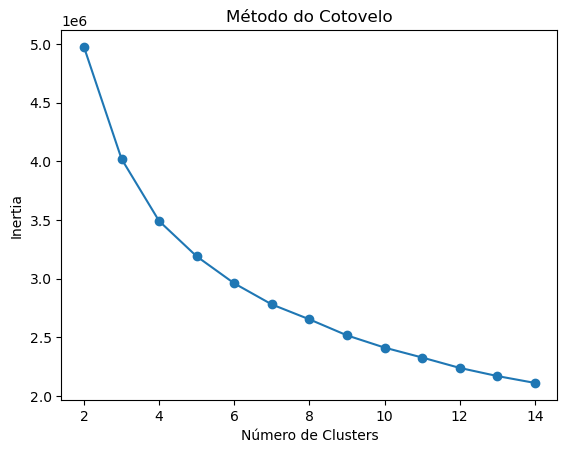

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Testar diferentes números de clusters
inertia = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico de inércia
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo')
plt.show()

#### 2.3.3 K-Means Model

In [25]:
k = 4 #com base na imagem acima
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
data['beer_style_cluster'] = kmeans.fit_predict(X_scaled)

In [26]:
clustered_styles = {}

# Agrupar por cluster e coletar estilos únicos
for cluster in range(k):
    unique_styles = data[data['beer_style_cluster'] == cluster]['beer_style'].unique().tolist()
    clustered_styles[cluster] = unique_styles

for cluster, styles in clustered_styles.items():
    print(f'Cluster {cluster}: {styles}')    

Cluster 0: ['Russian Imperial Stout', 'American Porter', 'American Double / Imperial Stout', 'American Barleywine', 'American Double / Imperial IPA', 'English Strong Ale', 'English Barleywine', 'Tripel', 'Flanders Oud Bruin', 'American Stout', 'Belgian Strong Pale Ale', 'American Strong Ale', 'American Black Ale', 'Scotch Ale / Wee Heavy', 'Pumpkin Ale', 'Winter Warmer', 'Belgian IPA', 'Black & Tan', 'American IPA', 'Belgian Strong Dark Ale', 'American Double / Imperial Pilsner', 'Euro Pale Lager', 'American Amber / Red Ale', 'Doppelbock', 'Dubbel', 'Baltic Porter', 'Old Ale', 'Quadrupel (Quad)', 'Wheatwine', 'Braggot', 'Oatmeal Stout', 'Lambic - Fruit', 'Weizenbock', 'Eisbock', 'Euro Strong Lager', 'Belgian Dark Ale', 'American Wild Ale', 'Scottish Ale', 'Lambic - Unblended', 'American Brown Ale', 'Rye Beer', 'Fruit / Vegetable Beer', 'Altbier', 'Irish Red Ale', 'American Malt Liquor', 'Saison / Farmhouse Ale', 'Maibock / Helles Bock', 'Herbed / Spiced Beer', 'Witbier', 'Smoked Beer',

## 3 Exploratory Data Analysis

### 3.1 Univariated Analysis

#### 3.1.1 Response Variable

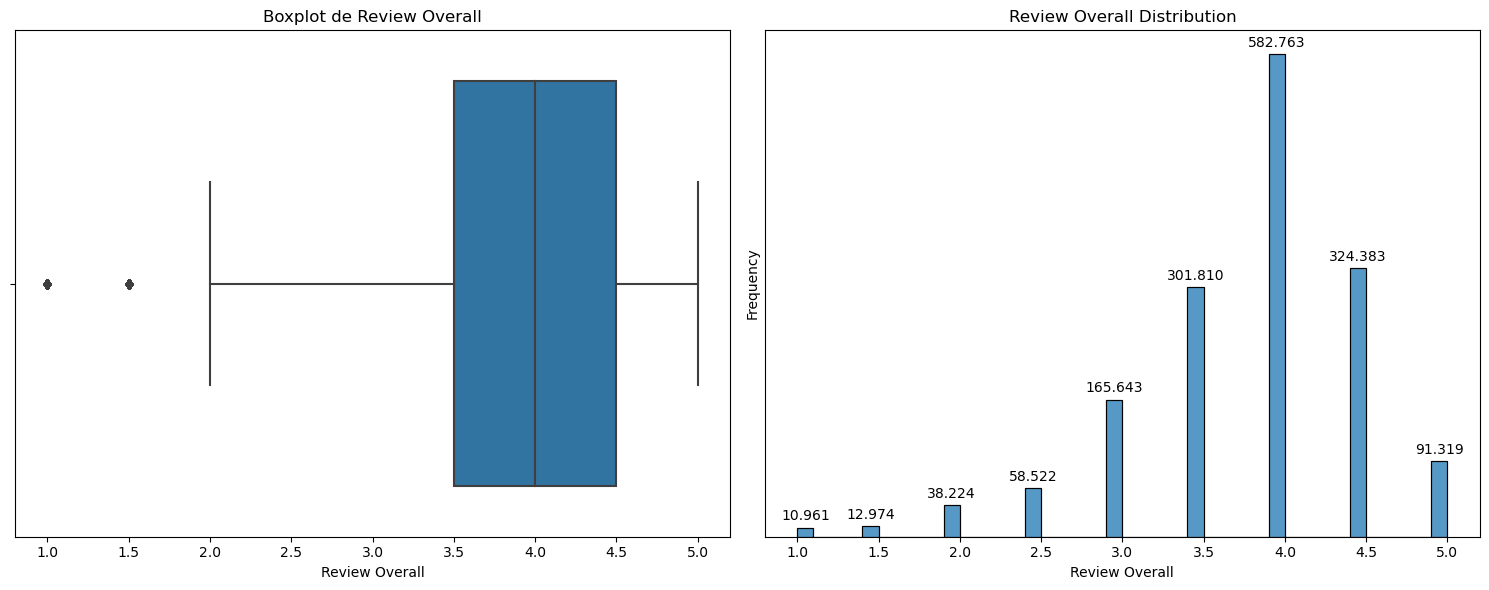

In [27]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1 - Boxplot de 'review_overall'
sns.boxplot(data=data, x='review_overall', ax=axes[0])
axes[0].set_title('Boxplot de Review Overall')
axes[0].set_xlabel('Review Overall')

# Gráfico 2 - Histograma de 'review_overall'
histplot = sns.histplot(data=data, x='review_overall', binwidth=0.1, ax=axes[1])

# Adicionando rótulos de frequência ao histograma com separador de milhar (ponto)
for patch in histplot.patches:
    height = patch.get_height()
    if height > 0:
        histplot.annotate(f'{int(height):,}'.replace(",", "."), 
                          xy=(patch.get_x() + patch.get_width() / 2, height), 
                          xytext=(0, 3), 
                          textcoords="offset points", 
                          ha='center', va='bottom')

# Configurações do eixo Y e títulos
axes[1].yaxis.set_ticks([])  # Remover ticks do eixo Y no histograma
axes[1].set_title('Review Overall Distribution')
axes[1].set_xlabel('Review Overall')
axes[1].set_ylabel('Frequency')

# Ajustar espaçamento entre os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### 3.1.2 Sensorial Variables

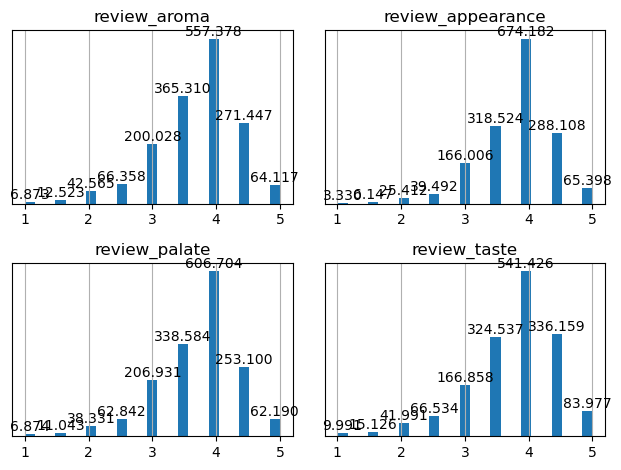

In [28]:
# Agrupar os dados
grouped_view = data[['review_aroma', 'review_appearance', 'review_palate', 'review_taste']]

# Criar histogramas
axes = grouped_view.hist(bins=25)

# Adicionar rótulos de dados, evitando zeros
for ax in axes.flatten():
    for p in ax.patches:  # Iterar sobre cada barra do histograma
        height = int(p.get_height())
        if height > 0:  # Verificar se a altura é maior que zero
            ax.annotate(f'{height:,}'.replace(',', '.'),  # Rótulo com a altura da barra e ponto como separador
                         (p.get_x() + p.get_width() / 2, height),  # Posição do rótulo
                         ha='center', va='bottom', fontsize=10)  # Ajustar o tamanho da fonte
    ax.set_yticks([])  # Ocultar o eixo y

# Exibir o gráfico
plt.tight_layout()
plt.show()

#### 3.1.3 Beer ABV

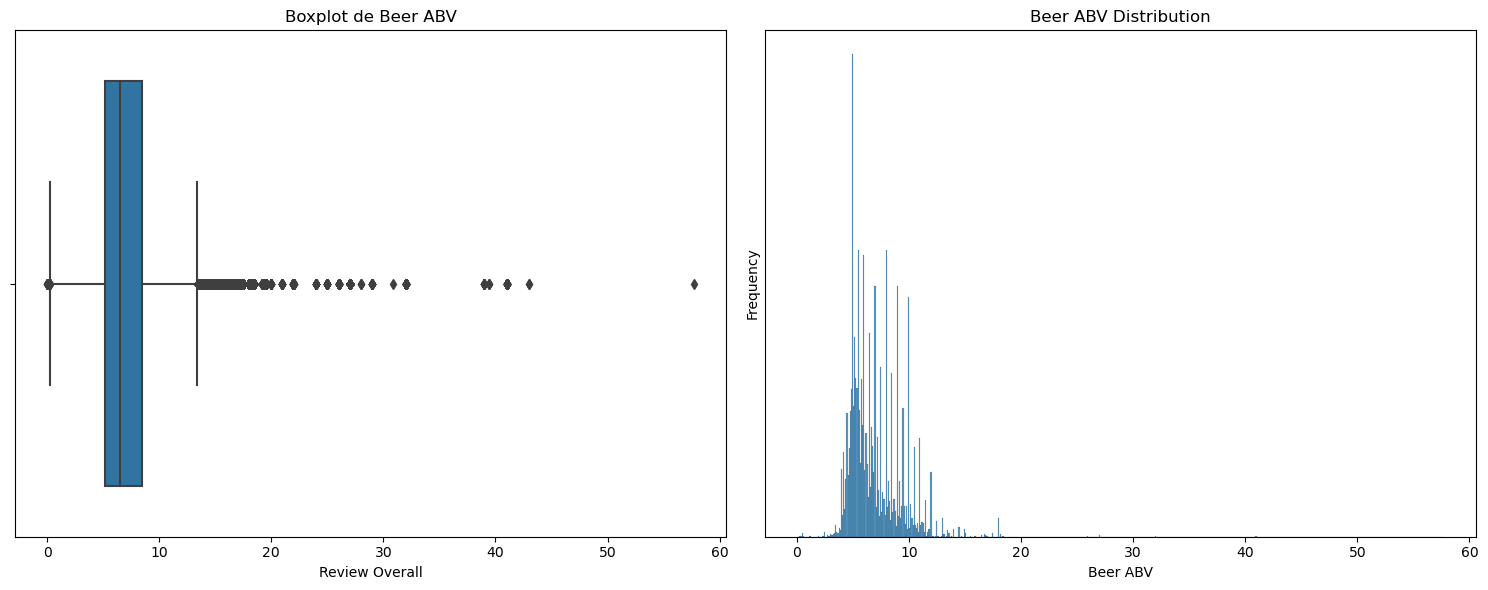

In [29]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1 - Boxplot de 'review_overall'
sns.boxplot(data=data, 
            x='beer_alcohol_by_volume',
            ax=axes[0])
axes[0].set_title('Boxplot de Beer ABV')
axes[0].set_xlabel('Review Overall')

# Gráfico 2 - Histograma de 'review_overall'
histplot = sns.histplot(data=data, 
                        x='beer_alcohol_by_volume',  
                        ax=axes[1],
                        binwidth=0.1)

# Configurações do eixo Y e títulos
axes[1].yaxis.set_ticks([])  # Remover ticks do eixo Y no histograma
axes[1].set_title('Beer ABV Distribution')
axes[1].set_xlabel('Beer ABV')
axes[1].set_ylabel('Frequency')

# Ajustar espaçamento entre os gráficos
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### 3.1.4 Categorical Variable

In [30]:
#contar as ocorrências de cada estilo de cerveja
cat_beer_style = pd.DataFrame(data['beer_style'].value_counts().reset_index())
cat_beer_style.columns = ['beer_style', 'count']
print(cat_beer_style.head(10))
print(cat_beer_style.tail(10))

                         beer_style   count
0                      American IPA  117584
1    American Double / Imperial IPA   85977
2           American Pale Ale (APA)   63469
3            Russian Imperial Stout   54129
4  American Double / Imperial Stout   50705
5                   American Porter   50477
6          American Amber / Red Ale   45751
7           Belgian Strong Dark Ale   37743
8            Fruit / Vegetable Beer   33861
9               American Strong Ale   31945
                          beer_style  count
94                Lambic - Unblended   1114
95                             Sahti   1061
96   Bière de Champagne / Bière Brut   1046
97                           Braggot   1040
98             English Pale Mild Ale    700
99                              Gose    686
100                             Faro    609
101                       Roggenbier    466
102                            Kvass    297
103                         Happoshu    241


### 3.2 Bivariated Analysis

In [31]:
initial_date =  data['review_time'].min() 
final_date = data['review_time'].max()
delta_time = relativedelta(final_date, initial_date)

print(f"Initial Date: {initial_date}")
print(f"Final Date: {final_date}")
print(f"Time Interval: {delta_time.years} years and {delta_time.years} months")

Initial Date: 1996-08-22 00:00:01
Final Date: 2012-01-11 12:35:48
Time Interval: 15 years and 15 months


#### 3.2.1 Response Variable

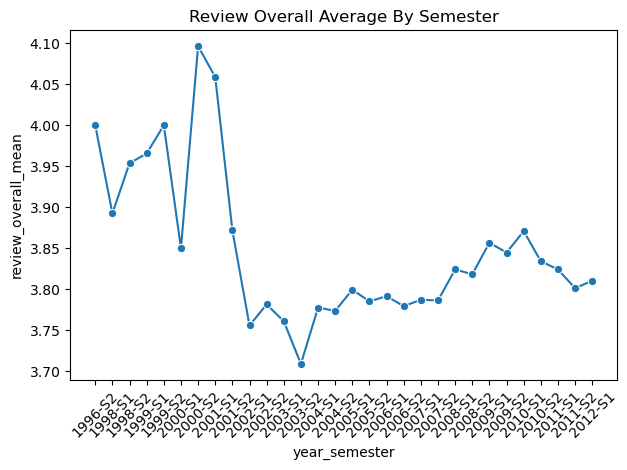

In [32]:
#criando o dataset base para o gráfico
review_overall_ts = data.groupby('year_semester')['review_overall'].mean().sort_index(ascending=True).reset_index()

#criando o grafico
sns.lineplot(x='year_semester', y='review_overall', data=review_overall_ts, marker='o')

#ajsutando rotação eixo x
plt.xticks(rotation=45)

plt.title('Review Overall Average By Semester')
plt.xlabel('year_semester')
plt.ylabel('review_overall_mean')

plt.tight_layout()
plt.show()


#### 3.2.2 Numerical Variables

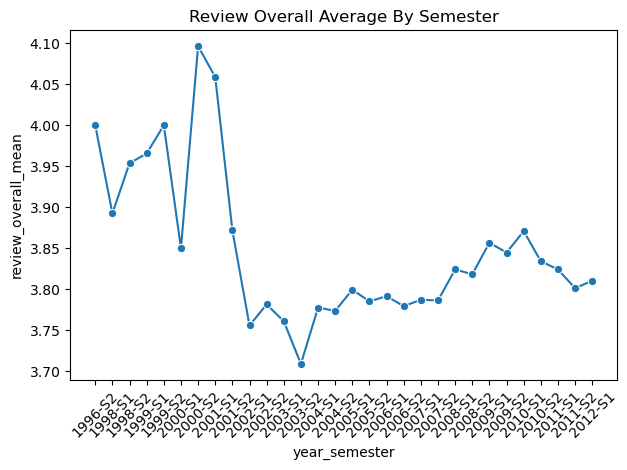

In [33]:
#criando o dataset base para o gráfico
review_overall_ts = data.groupby('year_semester')['review_overall'].mean().sort_index(ascending=True).reset_index()

#criando o grafico
sns.lineplot(x='year_semester', y='review_overall', data=review_overall_ts, marker='o')

#ajsutando rotação eixo x
plt.xticks(rotation=45)

plt.title('Review Overall Average By Semester')
plt.xlabel('year_semester')
plt.ylabel('review_overall_mean')

plt.tight_layout()
plt.show()

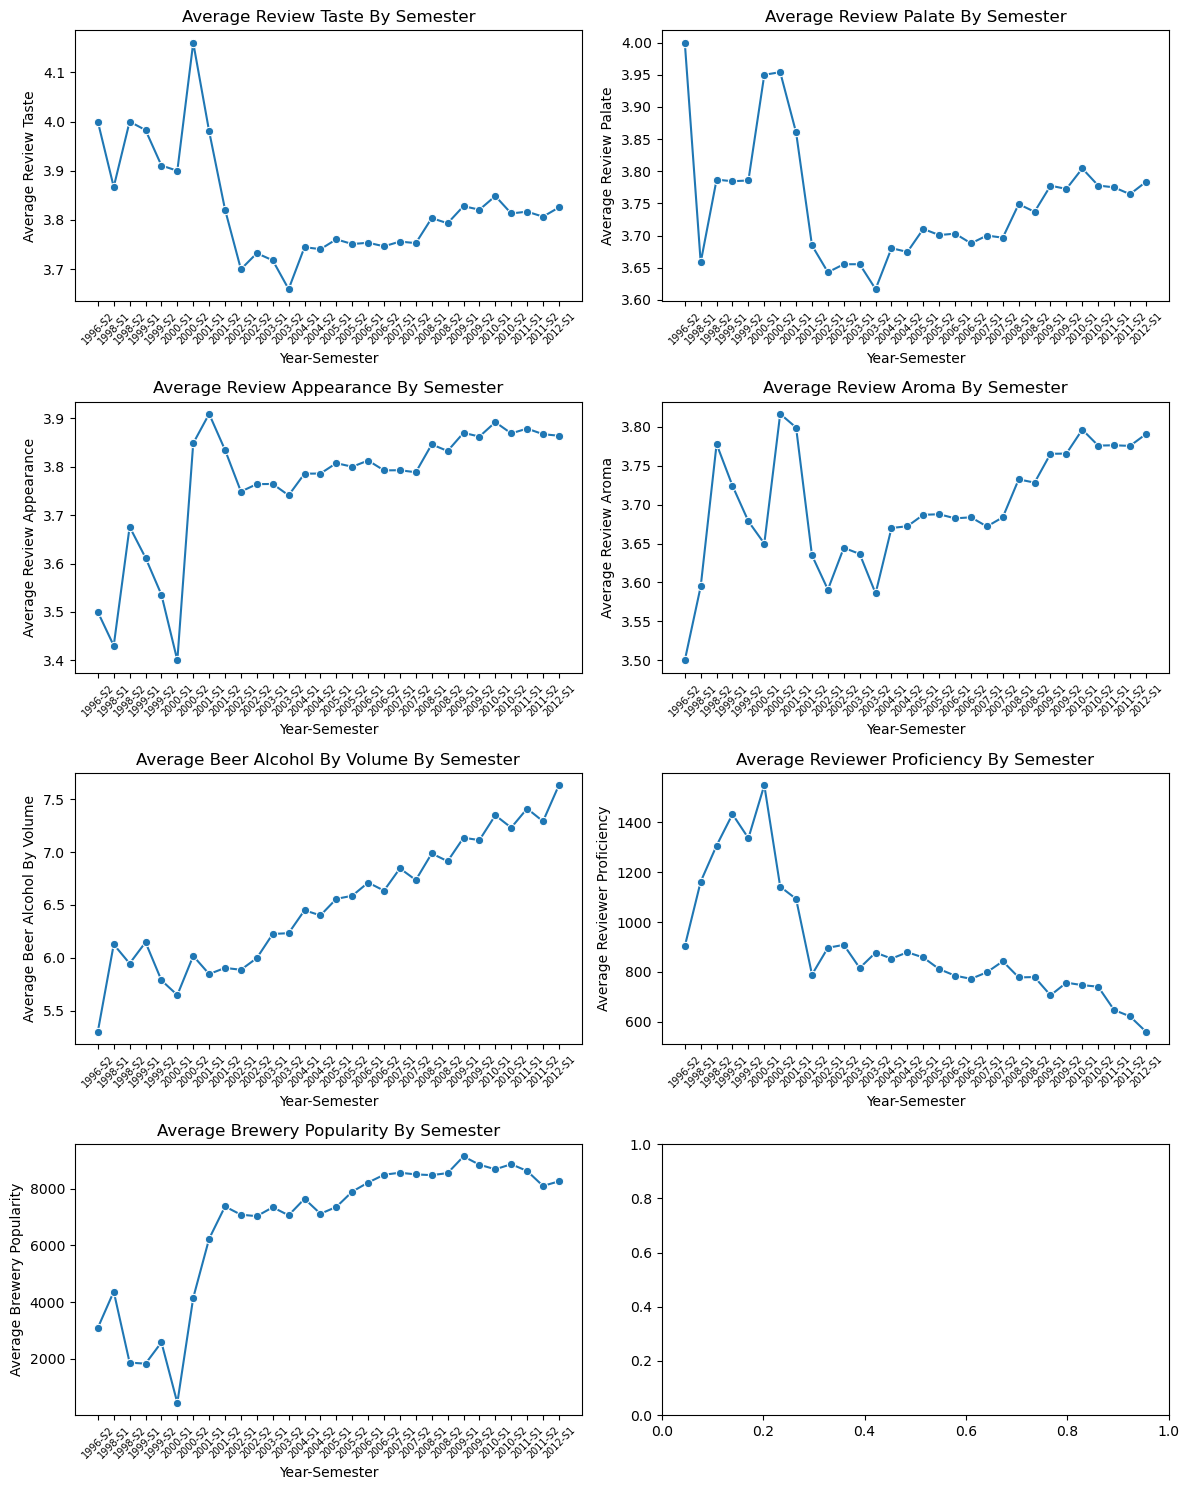

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variáveis a serem plotadas
variaveis = [
    'review_taste',
    'review_palate',
    'review_appearance',
    'review_aroma',
    'beer_alcohol_by_volume',
    'reviewer_proficiency',
    'brewery_popularity',
    ]

# Criar um gráfico para cada variável
n = len(variaveis)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
axes = axes.flatten()  # Facilitar a indexação

for i, var in enumerate(variaveis):
    # Criar o dataset base para cada gráfico
    ts = data.groupby('year_semester')[var].mean().sort_index(ascending=True).reset_index()

    # Criar o gráfico de linha
    sns.lineplot(x='year_semester', y=var, data=ts, marker='o', ax=axes[i])

    # Ajustar rotação eixo x
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)
    axes[i].set_title(f'Average {var.replace("_", " ").title()} By Semester')
    axes[i].set_xlabel('Year-Semester')
    axes[i].set_ylabel(f'Average {var.replace("_", " ").title()}')

plt.tight_layout()
plt.show()


### 3.3 Multivariated Analysis

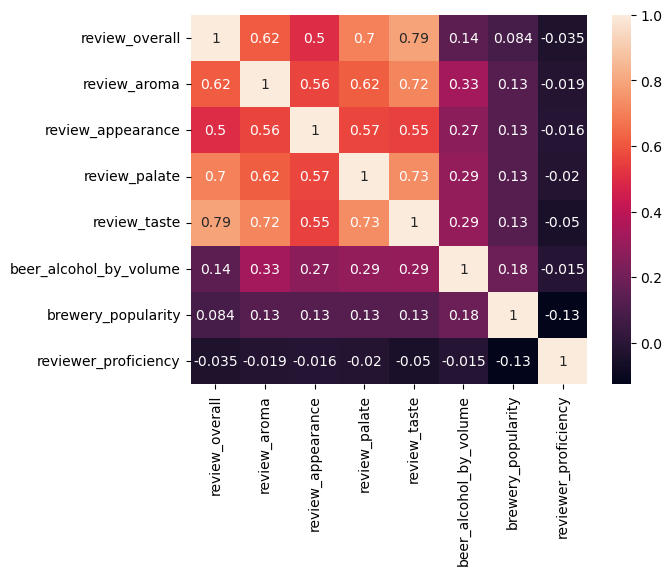

In [35]:
fig = figsize=(5, 5)

num_attributes = data.select_dtypes(include=['int64','float64'])

num_attributes = num_attributes[['review_overall', 'review_aroma', 'review_appearance', 'review_palate',
       'review_taste', 'beer_alcohol_by_volume', 'brewery_popularity', 'reviewer_proficiency']]

correlation = num_attributes.corr(method='pearson')
fig = sns.heatmap(correlation, annot=True);

## 4 Data Preparation

### 4.1 Standardization

In [36]:
features = ['beer_alcohol_by_volume', 'review_aroma', 'review_taste', 'review_palate', 'review_appearance']

#normalizando os dados --> média igual a zero e desvio padrão é igual a 1 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

### 4.2 Response Variable

In [37]:
y = data['review_overall']

### 4.3 Train/Test split

In [38]:
X_train_Scaled, X_test_Scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(X_train_Scaled.shape, X_test_Scaled.shape, y_train.shape, y_test.shape)

(1269279, 5) (317320, 5) (1269279,) (317320,)


### 4.4 Preparing X for Training

In [39]:
X_train_Scaled_Data_Frame = pd.DataFrame(X_train_Scaled)
X_test_Scaled_Data_Frame = pd.DataFrame(X_test_Scaled)

## 5 Model Training

### 5.1 Linear Regressor

In [61]:
#modelo
linear_regressor = LinearRegression().fit(X_train_Scaled, y_train)

#predição
linear_regressor_pred = linear_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
linear_regressor_pred_rounded = np.round(linear_regressor_pred / 0.5) * 0.5

#avaliando
linear_regressor_result = ml_error('Linear Regression', y_test, linear_regressor_pred_rounded)

#exibindo o resultado
linear_regressor_result

,Model Name,MAE,MAPE,RMSE,MSE
0,Linear Regression,0.28,0.08,0.44,0.19


In [64]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': linear_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.10%


In [65]:
result_df.head(20)

,True Value,Predicted Value,Correct
1232732,3.00,3.00,True
1088647,4.50,4.50,True
882884,4.00,4.00,True
396170,5.00,5.00,True
225287,4.00,3.00,False
503341,4.00,4.00,True
47961,3.00,3.50,False
356936,4.50,4.50,True
1190470,4.00,4.00,True
574992,4.50,4.50,True


#### 5.1.1 Linear Regressor Cross Validation

In [43]:
cross_validation(X_test_Scaled_Data_Frame, y_test, linear_regression, kfold=10)

,MAE,MSE,RMSE,MAPE
Mean,0.31,0.17,0.41,9.09
Std,0.00,0.00,0.00,0.08


### 5.2 Decision Tree Regressor

In [45]:
#definindo parâmetros
decision_tree_regressor = DecisionTreeRegressor(
    max_depth=15,             
    min_samples_split=10,     
    min_samples_leaf=5,       
    random_state=42
)

#modelo
decision_tree_regressor.fit(X_train_Scaled, y_train)

#predição
decision_tree_regressor_pred = decision_tree_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
decision_tree_regressor_pred_rounded = np.round(decision_tree_regressor_pred / 0.5) * 0.5

#avaliando
decision_tree_result = ml_error('Linear Regression', y_test, decision_tree_regressor_pred_rounded)

#exibindo o resultado
decision_tree_result


,Model Name,MAE,MAPE,RMSE,MSE
0,Linear Regression,0.28,0.08,0.44,0.19


In [66]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': decision_tree_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.23%


In [67]:
result_df.head(20)

,True Value,Predicted Value,Correct
1232732,3.00,3.00,True
1088647,4.50,4.50,True
882884,4.00,4.00,True
396170,5.00,4.50,False
225287,4.00,3.00,False
503341,4.00,4.00,True
47961,3.00,3.50,False
356936,4.50,4.50,True
1190470,4.00,4.00,True
574992,4.50,4.50,True


#### 5.2.1 Decision Tree Cross Validation

In [46]:
cross_validation(X_test_Scaled_Data_Frame, y_test, decision_tree_regressor, kfold=10)

,MAE,MSE,RMSE,MAPE
Mean,0.31,0.18,0.42,9.18
Std,0.00,0.00,0.00,0.08


### 5.2 XGBoost Regressor

In [47]:
#definindo parâmetros
xgb_regressor = XGBRegressor(
    max_depth=6,               # Profundidade máxima da árvore
    n_estimators=100,          # Número de árvores no ensemble
    learning_rate=0.1,         # Taxa de aprendizado
    subsample=0.8,             # Proporção de amostras usadas para treinar cada árvore
    colsample_bytree=0.8,      # Proporção de features usadas para cada árvore
    random_state=42
)

#modelo
xgb_regressor.fit(X_train_Scaled, y_train)

#predição
xgb_regressor_pred = xgb_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
xgb_regressor_pred_rounded = np.round(xgb_regressor_pred / 0.5) * 0.5

#avaliando
xgb_regressor_result = ml_error('Linear Regression', y_test, xgb_regressor_pred_rounded)

#exibindo o resultado
xgb_regressor_result

,Model Name,MAE,MAPE,RMSE,MSE
0,Linear Regression,0.28,0.08,0.43,0.18


In [68]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': xgb_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.74%


In [69]:
result_df.head(20)

,True Value,Predicted Value,Correct
1232732,3.00,3.00,True
1088647,4.50,4.50,True
882884,4.00,4.00,True
396170,5.00,4.50,False
225287,4.00,3.00,False
503341,4.00,4.00,True
47961,3.00,3.50,False
356936,4.50,4.50,True
1190470,4.00,4.00,True
574992,4.50,4.50,True


#### 5.2.1 XGBoost Cross Validation

In [48]:
cross_validation(X_test_Scaled_Data_Frame, y_test, xgb_regressor, kfold=10)

,MAE,MSE,RMSE,MAPE
Mean,0.31,0.16,0.40,8.89
Std,0.00,0.00,0.00,0.07


### 5.3 Random Forest Regressor

In [50]:
#definindo parâmetros
rf_regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=10,              # Profundidade máxima das árvores
    min_samples_split=10,      # Número mínimo de amostras para dividir um nó
    min_samples_leaf=5,        # Número mínimo de amostras por folha
    random_state=42
)

#modelo
rf_regressor.fit(X_train_Scaled, y_train)

#predição
rf_regressor_pred = rf_regressor.predict(X_test_Scaled)

#arredondamento para ficar nos padrões 0,5 em 0,5
rf_regressor_pred_rounded = np.round(rf_regressor_pred / 0.5) * 0.5

#avaliando
rf_regressor_result = ml_error('Linear Regression', y_test, rf_regressor_pred_rounded)

#exibindo o resultado
rf_regressor_result

,Model Name,MAE,MAPE,RMSE,MSE
0,Linear Regression,0.28,0.08,0.43,0.19


In [70]:
result_df = pd.DataFrame({
    'True Value': y_test,
    'Predicted Value': rf_regressor_pred_rounded
})

result_df['Correct'] = result_df['True Value'] == result_df['Predicted Value']

# Calculando o percentual de acerto
accuracy = result_df['Correct'].mean() * 100
print(f'Percentual de acerto: {accuracy:.2f}%')

Percentual de acerto: 51.59%


In [71]:
result_df.head(20)

,True Value,Predicted Value,Correct
1232732,3.00,3.00,True
1088647,4.50,4.50,True
882884,4.00,4.00,True
396170,5.00,4.50,False
225287,4.00,3.00,False
503341,4.00,4.00,True
47961,3.00,3.50,False
356936,4.50,4.50,True
1190470,4.00,4.00,True
574992,4.50,4.00,False


#### 5.3.1 Random Fores Cross Validation

In [51]:
cross_validation(X_test_Scaled_Data_Frame, y_test, rf_regressor, kfold=10)

,MAE,MSE,RMSE,MAPE
Mean,0.31,0.17,0.41,8.93
Std,0.00,0.00,0.00,0.07
